In [1]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"

import os
import sys
import random
import warnings
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import ShuffleSplit
import cv2
from scipy import ndimage
import time
import datetime
from image import ImageDataGenerator

seed = 42
random.seed = seed
np.random.seed = seed

# get package versions
def get_version(*vars):
    for var in vars:
        module = __import__(var)    
        print ('%s: %s' %(var,module.__version__))
    
# package version    
get_version('keras','numpy','matplotlib','cv2','theano')


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 20.0% of memory, cuDNN 5110)


keras: 2.1.3
numpy: 1.13.3
matplotlib: 2.1.0
cv2: 2.4.13
theano: 0.9.0.dev-425cb8effc7958e8ca376b023d8344b7620a9622


## Settings

In [2]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = '../data/stage1_train/'
TEST_PATH = '../data/stage1_test/'

# normalization type
norm_type='zeroMeanUnitStd'
norm_type=None

netinfo='trainTest3'
initialLearningRate=3e-4


# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

## Utilities

In [3]:
# random data generator
datagen = ImageDataGenerator(featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.01,
        zoom_range=0.01,
        channel_shift_range=0.0,
        fill_mode='constant',
        cval=0.0,
        horizontal_flip=True,
        vertical_flip=True,)
        #data_format="channels_first") 
    
# calcualte dice
def calc_dice(X,Y,d=0):
    N=X.shape[d]    
    # intialize dice vector
    dice=np.zeros([N,1])

    for k in range(N):
        x=X[k,0] >.5 # convert to logical
        y =Y[k,0]>.5 # convert to logical

        # number of ones for intersection and union
        intersectXY=np.sum((x&y==1))
        unionXY=np.sum(x)+np.sum(y)

        if unionXY!=0:
            dice[k]=2* intersectXY/(unionXY*1.0)
            #print 'dice is: %0.2f' %dice[k]
        else:
            dice[k]=1
            #print 'dice is: %0.2f' % dice[k]
        #print 'processing %d, dice= %0.2f' %(k,dice[k])
    return np.mean(dice),dice

def preprocess(X,xnormType=None):
    if xnormType=='minus1plus1':
        X=X.astype('float32')
        X/=np.max(X)
        X-=0.5
        X=X*2
    elif xnormType=='zeroMeanUnitStd':
        X=X.astype('float32')
        # we do this per channel
        for c in range(X.shape[1]):
            X[:,c]-=np.mean(X[:,c])
            stdXc=np.std(X[:,c])
            if stdXc>0.0:
                X[:,c]/=stdXc
    elif xnormType is None:
        pass
    else:
        raise IOError('normalization type not found!')
    return X

def array_stats(X):
    X=np.asarray(X)
    print ('array shape: ',X.shape, X.dtype)
    #print 'min: %.3f, max:%.3f, avg: %.3f, std:%.3f' %(np.min(X),np.max(X),np.mean(X),np.std(X))
    print ('min: {}, max: {}, avg: {:.3}, std:{:.3}'.format( np.min(X),np.max(X),np.mean(X),np.std(X)))

def resizeY(Y,origHW):
    # Y shape is N*1*H*W
    N=Y.shape[0] 
    Yr=[]
    for k in range(N):
        temp=resize(Y[k,0], (origHW[k,0], origHW[k,1]), mode='constant', preserve_range=True)
        
        #Yr.append(np.array(temp,'uint8'))
        Yr.append(temp)
    return Yr

def resizeX(X,origHW):
    # Y shape is N*1*H*W
    N=X.shape[0] 
    Xr=[]
    for k in range(N):
        Xk=X[k]
        Xk=np.transpose(Xk,(1,2,0))
        temp=resize(Xk, (origHW[k,0], origHW[k,1]), mode='constant', preserve_range=True)
        temp=np.transpose(temp,(2,0,1))
        Xr.append(np.array(temp,'uint8'))
    return Xr

def loadData0(ids,path2data):
    print('loading '+path2data)
    # Get and resize train images and masks
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    origHW=np.zeros((len(ids),3),dtype='uint16') # store original dimension for later use
    
    print('Getting and resizing images and masks ... ')
    #sys.stdout.flush()
    for n, id_ in enumerate(ids):
        path = path2data + id_   
        #print(path)
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        h,w,c=img.shape
        origHW[n]=img.shape
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        try:
            for mask_file in next(os.walk(path + '/masks/'))[2]:
                mask_ = imread(path + '/masks/' + mask_file)
                mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                              preserve_range=True), axis=-1)
                mask = np.maximum(mask, mask_)
            Y[n] = mask
        except:
            Y=[]
    if len(Y):
        Y=np.transpose(Y,(0,3,1,2))
    return np.transpose(X,(0,3,1,2)),Y,origHW


def loadData(path2h5,data_type='train'):
    if not os.path.exists(path2h5):
        X_train,Y_train,HW_train=loadData0(train_ids,TRAIN_PATH)
        h5file=h5py.File(path2h5,'w-')
        h5file['X_train']=X_train
        h5file['Y_train']=Y_train
        h5file['HW_train']=HW_train
            
        X_test,Y_test,HW_test=loadData0(test_ids,TEST_PATH)
        h5file['X_test']=X_test
        h5file['Y_test']=Y_test
        h5file['HW_test']=HW_test
    else:
        print('loading '+ path2h5)
        h5file=h5py.File(path2h5,'r')
        X_train=h5file['X_train']
        Y_train=h5file['Y_train']
        HW_train=h5file['HW_train']
        
        X_test=h5file['X_test']
        Y_test=h5file['Y_test']
        HW_test=h5file['HW_test']
        
    if data_type=="train":
        return X_train,Y_train,np.array(HW_train,'uint16')
    elif data_type=="leader":
        return X_test,Y_test,np.array(HW_test,'uint16')


def iterate_minibatches(inputs1 , targets,  batchsize, shuffle=True, augment=True):
    assert len(inputs1) == len(targets)
    if augment==True:
        if shuffle:
            indices = np.arange(len(inputs1))
            np.random.shuffle(indices)
        for start_idx in range(0, len(inputs1) - batchsize + 1, batchsize):
            if shuffle:
                excerpt = indices[start_idx:start_idx + batchsize]
            else:
                excerpt = slice(start_idx, start_idx + batchsize)
            x = inputs1[excerpt]
            y = targets[excerpt] 
            for  xxt,yyt in datagen.flow(x, y , batch_size=x.shape[0]):
                x = xxt.astype(np.float32) 
                y = yyt 
                break
    else:
        x=inputs1
        y=targets

    #yield np.array(x,np.uint8), np.array(y, dtype=np.uint8)         
    return np.array(x,np.uint8), np.array(y, dtype=np.uint8)     
    
    
# train test model
def train_test_model(X_train,y_train,X_test,y_test,params_train):
    foldnm=params_train['foldnm']  
    pre_train=params_train['pre_train'] 
    batch_size=params_train['batch_size'] 
    augmentation=params_train['augmentation'] 
    path2weights=params_train['path2weights'] 
    path2model=params_train['path2model'] 
    norm_type=params_train['norm_type'] 
    
    print('batch_size: %s, Augmentation: %s' %(batch_size,augmentation))
    
    print 'fold %s training in progress ...' %foldnm
    # load last weights
    if pre_train== True:
        if  os.path.exists(path2weights):
            model.load_weights(path2weights)
            print 'previous weights loaded!'
        else:
            raise IOError('weights does not exist!!!')
    else:
        if  os.path.exists(path2weights):
            model.load_weights(path2weights)
            print (path2weights)
            print ('previous weights loaded!')
            train_status='previous weights'
            return train_status
    
    # path to csv file to save scores
    path2scorescsv = weightfolder+'/scores.csv'
    first_row = 'train,test'
    with open(path2scorescsv, 'w+') as f:
        f.write(first_row + '\n')
           
    # Fit the model
    start_time=time.time()
    scores_test=[]
    scores_train=[]
    if params_train['loss']=='dice': 
        best_score = 0
        previous_score = 0
    else:
        best_score = 1e6
        previous_score = 1e6
    patience = 0
    
    # convert class vectors to binary class matrices
    
    
    for epoch in range(params_train['nbepoch']):
    
        print ('epoch: %s,  Current Learning Rate: %.1e' %(epoch,model.optimizer.lr.get_value()))
        #seed = np.random.randint(0, 999999)
    
        if augmentation:
            X_batch,Y_batch=iterate_minibatches(X_train,y_train,X_train.shape[0],shuffle=False,augment=True)  
            Y_batch=Y_batch[:,0][:,np.newaxis]
            #model.fit_generator(train_generator, steps_per_epoch=len(xtr)/batch_size, epochs=1,verbose=0)            
            hist=model.fit(preprocess(X_batch,norm_type), Y_batch, batch_size=batch_size,epochs=1, verbose=0)
        else:
            hist=model.fit(preprocess(X_train,norm_type), y_train, batch_size=batch_size,epochs=1, verbose=0)
            
        # evaluate on test and train data
        score_test=model.evaluate(preprocess(X_test,norm_type),y_test,verbose=0)
        score_train=np.mean(hist.history['loss'])
       
        print ('score_train: %s, score_test: %s' %(score_train,score_test))
        scores_test=np.append(scores_test,score_test)
        scores_train=np.append(scores_train,score_train)    

        # check for improvement    
        if (score_test<=best_score):
            print ("!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!") 
            best_score = score_test
            patience = 0
            model.save_weights(path2weights)  
            model.save(path2model)
            
        # learning rate schedule
        if score_test>previous_score:
            #print "Incrementing Patience."
            patience += 1

        # learning rate schedule                
        if patience == params_train['max_patience']:
            params_train['learning_rate'] = params_train['learning_rate']/2
            print ("Upating Current Learning Rate to: ", params_train['learning_rate'])
            model.optimizer.lr.set_value(params_train['learning_rate'])
            print ("Loading the best weights again. best_score: ",best_score)
            model.load_weights(path2weights)
            patience = 0
        
        # save current test score
        previous_score = score_test    
        
        # store scores into csv file
        with open(path2scorescsv, 'a') as f:
            string = str([score_train,score_test])
            f.write(string + '\n')
           
    
    print ('model was trained!')
    elapsed_time=(time.time()-start_time)/60
    print ('elapsed time: %d  mins' %elapsed_time)      

    # train test progress plots
    plt.figure(figsize=(10,10))
    plt.plot(scores_test)
    plt.plot(scores_train)
    plt.title('train-validation progress',fontsize=20)
    plt.legend(('test','train'),fontsize=20)
    plt.xlabel('epochs',fontsize=20)
    plt.ylabel('loss',fontsize=20)
    plt.grid(True)
    plt.savefig(weightfolder+'/train_val_progress.png')
    plt.show()
    
    print 'training completed!'
    train_status='completed!'
    return train_status    

def grays_to_RGB(img):
    # turn 2D grayscale image into grayscale RGB
    return np.dstack((img, img, img))


def image_with_mask(img, mask,color=(0,255,0)):
    mask=np.asarray(mask,dtype='uint8') 
    
    if len(img.shape)==2:
        img_color = grays_to_RGB(img)
    else:
        img_color =img

    mask2=mask[:,:,0]
    for c1 in range(mask.shape[2]):
        mask2=np.logical_or(mask2,mask[:,:,c1])
    mask2=np.array(255*mask2,'uint8')
        
    mask_edges = cv2.Canny(mask2, 100, 200) > 0
    #plt.imshow(mask_edges)
    maximg=np.max(img)
    img_color[mask_edges, 0] = maximg*color[0]  # set channel 0 to bright red, green & blue channels to 0
    img_color[mask_edges, 1] = maximg*color[1]
    img_color[mask_edges, 2] = maximg*color[2]
    return img_color

def disp_img_2masks(img,mask1=None,mask2=None,r=1,c=1,d=0,indices=None):
    if mask1 is None:
        mask1=np.zeros(img.shape,dtype='uint8')
    else:
        mask1=np.array(mask1,dtype='uint8')
    if mask2 is None:
        mask2=np.zeros(img.shape,dtype='uint8')
    else:        
        mask2=np.array(mask2,dtype='uint8')    
        
    N=r*c    
    if d==2:
        # convert to N*C*H*W
        img=np.transpose(img,(2,0,1))
        img=np.expand_dims(img,axis=1)
        
        mask1=np.transpose(mask1,(2,0,1))
        mask1=np.expand_dims(mask1,axis=1)

        mask2=np.transpose(mask2,(2,0,1))
        mask2=np.expand_dims(mask2,axis=1)
        
    if indices is None:    
        indices=np.random.randint(img.shape[0],size=N)
    
    # collect images and masks
    I1=[np.transpose(img[i],(1,2,0)) for i in indices]
    M1=[np.transpose(mask1[i],(1,2,0)) for i in indices]
    M2=[np.transpose(mask2[i],(1,2,0)) for i in indices]
    
    C1=(0,255,0)
    C2=(255,0,0)
    for k in range(N):    
        imgmask=image_with_mask(I1[k],M1[k],C1)
        imgmask=image_with_mask(imgmask,M2[k],C2)
        plt.subplot(r,c,k+1)
        plt.imshow(imgmask)
        plt.title(indices[k])
    plt.show()            
    


## loading data

loading ../data/trainTestH128W128.hdf5
('array shape: ', (670, 3, 128, 128), dtype('uint8'))
min: 0, max: 255, avg: 43.4, std:68.5
('array shape: ', (670, 1, 128, 128), dtype('bool'))
min: False, max: True, avg: 0.153, std:0.36
('array shape: ', (670, 3), dtype('uint16'))
min: 3, max: 1388, avg: 2.38e+02, std:2.22e+02


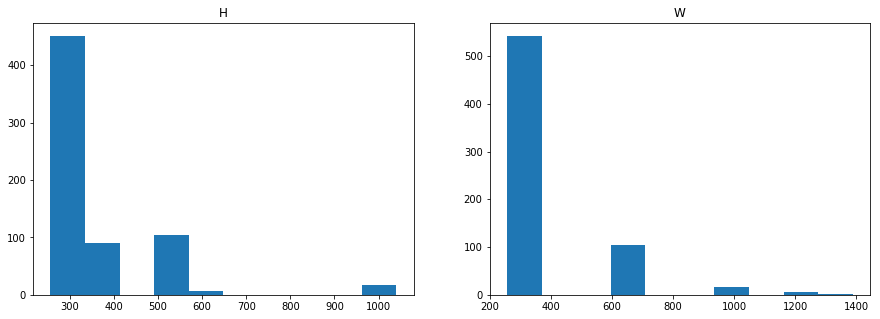

In [4]:
path2h5='../data/trainTestH'+str(IMG_HEIGHT)+'W'+str(IMG_WIDTH)+'.hdf5'
X,Y,HW_train=loadData(path2h5,'train')
array_stats(X)
array_stats(Y)
array_stats(HW_train)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(HW_train[:,0])
plt.title('H')
plt.subplot(1,2,2)
plt.hist(HW_train[:,1])
plt.title('W')
plt.show()

## Display data

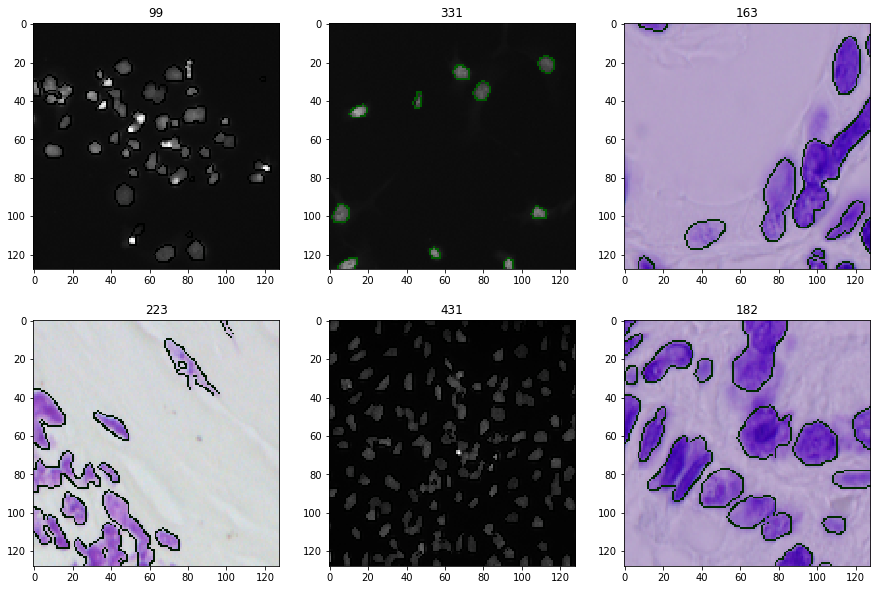

In [5]:
plt.figure(figsize=(15,10))
disp_img_2masks(img=X,mask1=Y,r=2,c=3)

## AI model

In [6]:
from keras.layers import Input, merge, Convolution2D, Deconvolution2D, AtrousConvolution2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Dense
from keras.layers.core import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.utils import layer_utils
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose
from keras.layers import Concatenate
from keras.layers import AtrousConv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Dense
from keras.layers.core import Activation
from keras.layers import Activation,Reshape,Permute
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.utils import layer_utils
from keras.layers.normalization import BatchNormalization

# model
def model_skip(params):

    h=params['h']
    w=params['w']
    z=params['z']
    lr=params['learning_rate']
    loss=params['loss']
    C=params['initial_channels']
    nb_output=params['num_labels']
    dropout_rate=params['dropout_rate']
    data_format='channels_first'
    batchNorm=params['batchNorm']
    w2reg=params['w2reg']
    initStride=params['initStride']
    reshape4softmax=params['reshape4softmax']
    
    
    inputs = Input((z,h, w))
    conv1 = Conv2D(C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg,strides=initStride)(inputs)
    if batchNorm:
        conv1=BatchNormalization(axis=1)(conv1)
    conv1=Activation('relu')(conv1)        
    
    conv1 = Conv2D(C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(conv1)
    if batchNorm:
        conv1=BatchNormalization(axis=1)(conv1)
    conv1=Activation('relu')(conv1)        

    pool1 = MaxPooling2D(pool_size=(2, 2),data_format=data_format)(conv1)

    conv2 = Conv2D(2*C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(pool1)
    if batchNorm:
        conv2=BatchNormalization(axis=1)(conv2)
    conv2=Activation('relu')(conv2)        
    
    conv2 = Conv2D(2*C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(conv2)
    if batchNorm:
        conv2=BatchNormalization(axis=1)(conv2)
    conv2=Activation('relu')(conv2)        
    
    pool2 = MaxPooling2D(pool_size=(2, 2),data_format=data_format)(conv2)

    conv3 = Conv2D(4*C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(pool2)
    if batchNorm:
        conv3=BatchNormalization(axis=1)(conv3)
    conv3=Activation('relu')(conv3)        
    
    conv3 = Conv2D(4*C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(conv3)
    if batchNorm:
        conv3=BatchNormalization(axis=1)(conv3)
    conv3=Activation('relu')(conv3)        
    
    pool3 = MaxPooling2D(pool_size=(2, 2),data_format=data_format)(conv3)

    conv4 = Conv2D(8*C, 3,  padding='same',data_format=data_format,kernel_regularizer=w2reg)(pool3)
    if batchNorm:
        conv4=BatchNormalization(axis=1)(conv4)
    conv4=Activation('relu')(conv4)        
    
    conv4 = Conv2D(8*C, 3,  padding='same',data_format=data_format,kernel_regularizer=w2reg)(conv4)
    if batchNorm:
        conv4=BatchNormalization(axis=1)(conv4)
    conv4=Activation('relu')(conv4)        
    
    pool4 = MaxPooling2D(pool_size=(2, 2),data_format=data_format)(conv4)

    conv5 = Conv2D(16*C,  3,  padding='same',data_format=data_format,kernel_regularizer=w2reg)(pool4)
    if batchNorm:
        conv5=BatchNormalization(axis=1)(conv5)
    conv5=Activation('relu')(conv5)        
    
    conv5 = Conv2D(16*C, 3,  padding='same',data_format=data_format,kernel_regularizer=w2reg)(conv5)
    if batchNorm:
        conv5=BatchNormalization(axis=1)(conv5)
    conv5=Activation('relu')(conv5)        
    
    conv5 =Dropout(dropout_rate)(conv5)
    #pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    
    up7=UpSampling2D(size=(2, 2),data_format=data_format)(conv5)
    concat = Concatenate(axis=1)
    up7 = concat([up7, conv4])
    conv7 = Conv2D(8*C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(up7)
    if batchNorm:
        conv7=BatchNormalization(axis=1)(conv7)
    conv7=Activation('relu')(conv7)        
    
    up8 = concat([UpSampling2D(size=(2, 2),data_format=data_format)(conv7), conv3])
    conv8 = Conv2D(4*C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(up8)
    if batchNorm:
        conv8=BatchNormalization(axis=1)(conv8)
    conv8=Activation('relu')(conv8)        
    
    up9 = concat([UpSampling2D(size=(2, 2),data_format=data_format)(conv8), conv2])
    conv9 = Conv2D(2*C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(up9)
    if batchNorm:
        conv9=BatchNormalization(axis=1)(conv9)
    conv9=Activation('relu')(conv9)        
    

    up10 = concat([UpSampling2D(size=(2, 2),data_format=data_format)(conv9), conv1])
    conv10 = Conv2D(C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(up10)
    if batchNorm:
        conv10=BatchNormalization(axis=1)(conv10)
    conv10=Activation('relu')(conv10)        
    
    conv10 = UpSampling2D(size=(initStride, initStride),data_format=data_format)(conv10)
    if batchNorm:
        conv10=BatchNormalization(axis=1)(conv10)
    conv10=Activation('relu')(conv10)        
    
    conv10 = Conv2D(C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(conv10)
    if batchNorm:
        conv10=BatchNormalization(axis=1)(conv10)
    conv10=Activation('relu')(conv10)        
    
    conv10 = Conv2D(nb_output, 1, data_format=data_format,kernel_regularizer=w2reg)(conv10)

    if reshape4softmax:
        # reshape for softmax
        output=Reshape((nb_output,h*w)) (conv10)
        # permute for softmax
        output=Permute((2,1))(output)
        # softmax
        output=Activation('softmax')(output)
    else:        
        output=Activation('sigmoid')(conv10)
    
    model = Model(inputs=inputs, outputs=output)

    if loss=='dice':
        model.compile(optimizer=Adam(lr), loss=dice_coef_loss, metrics=[dice_coef])
    else:
        #model.compile(loss='binary_crossentropy', optimizer=Adam(lr))
        model.compile(loss=loss, optimizer=Adam(lr))
    
    return model

In [7]:
n,z,h,w=X.shape
params_train={
    'h': h,
    'w': w,
    'z':z,
    'learning_rate': initialLearningRate,
    'optimizer': 'Adam',
    #'loss': 'categorical_crossentropy',
    'loss': 'binary_crossentropy',
    'nbepoch': 200 ,
    'num_labels': 1,
    'initial_channels':16,
    'dropout_rate': 0.5,
    'max_patience': 30,
    'experiment': None,
    'pre_train': False,
    'elastic_arg': None,
    'trainaug_params': None,
    'batch_size': 10,
    'weightfolder': None,
    'w2reg': None, #regularizers.l2(1e-4),    
    'batchNorm': False,
    'initStride': 2,
    'norm_type': norm_type,
    'augmentation': True,
    'reshape4softmax': False,
    }
    
model = model_skip(params_train)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 128, 128)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 64, 64)   448         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 64, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 64, 64)   2320        activation_1[0][0]               
__________________________________________________________________________________________________
activation

conv2d_14 (Conv2D)              (None, 16, 64, 64)   6928        concatenate_1[3][0]              
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 16, 64, 64)   0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_5 (UpSampling2D)  (None, 16, 128, 128) 0           activation_14[0][0]              
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 16, 128, 128) 0           up_sampling2d_5[0][0]            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 128, 128) 2320        activation_15[0][0]              
__________________________________________________________________________________________________
activation

wait ...
('array shape: ', (603, 3, 128, 128), dtype('uint8'))
min: 0, max: 255, avg: 43.6, std:69.0
('array shape: ', (603, 1, 128, 128), dtype('uint8'))
min: 0, max: 1, avg: 0.153, std:0.36
('array shape: ', (67, 3, 128, 128), dtype('uint8'))
min: 0, max: 255, avg: 41.1, std:63.0
('array shape: ', (67, 1, 128, 128), dtype('uint8'))
min: 0, max: 1, avg: 0.152, std:0.359
------------------------------
('experiment:', 'trainTest3_hw_128by128_initfilts_16')
batch_size: 10, Augmentation: True
fold 1 training in progress ...
./output/weights/trainTest3_hw_128by128_initfilts_16/fold1/weights.hdf5
previous weights loaded!
weights loaded!
score_test: 0.06407
average dice: 0.92
------------------------------
('array shape: ', (603, 3, 128, 128), dtype('uint8'))
min: 0, max: 255, avg: 43.6, std:68.5
('array shape: ', (603, 1, 128, 128), dtype('uint8'))
min: 0, max: 1, avg: 0.151, std:0.358
('array shape: ', (67, 3, 128, 128), dtype('uint8'))
min: 0, max: 255, avg: 41.6, std:68.6
('array shape: 

score_train: 0.0644340052163, score_test: 0.0702463134901
epoch: 56,  Current Learning Rate: 3.0e-04
score_train: 0.0612089837381, score_test: 0.0695207981921
epoch: 57,  Current Learning Rate: 3.0e-04
score_train: 0.0625695126412, score_test: 0.0671476981978
epoch: 58,  Current Learning Rate: 3.0e-04
score_train: 0.0601701961697, score_test: 0.0659912924713
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 59,  Current Learning Rate: 3.0e-04
score_train: 0.0596508060645, score_test: 0.0718403285119
epoch: 60,  Current Learning Rate: 3.0e-04
score_train: 0.0604335007136, score_test: 0.0709290933698
epoch: 61,  Current Learning Rate: 3.0e-04
score_train: 0.0617048361865, score_test: 0.0662880944672
epoch: 62,  Current Learning Rate: 3.0e-04
score_train: 0.0617250758061, score_test: 0.0681016409575
epoch: 63,  Current Learning Rate: 3.0e-04
score_train: 0.0630948684714, score_test: 0.0668757646831
epoch: 64,  Current Learning Rate: 3.0e-04
score_train: 0.059

score_train: 0.0521177971986, score_test: 0.0667493805956
epoch: 134,  Current Learning Rate: 3.0e-04
score_train: 0.0518150047567, score_test: 0.0686333286228
epoch: 135,  Current Learning Rate: 3.0e-04
score_train: 0.0533103534757, score_test: 0.0717941622681
epoch: 136,  Current Learning Rate: 3.0e-04
score_train: 0.0616016824904, score_test: 0.0825792746757
epoch: 137,  Current Learning Rate: 3.0e-04
score_train: 0.0594317190485, score_test: 0.0667841776983
epoch: 138,  Current Learning Rate: 3.0e-04
score_train: 0.055107905219, score_test: 0.066478065368
epoch: 139,  Current Learning Rate: 3.0e-04
score_train: 0.0527844607002, score_test: 0.0649882628402
epoch: 140,  Current Learning Rate: 3.0e-04
score_train: 0.0508457647627, score_test: 0.0667655932814
epoch: 141,  Current Learning Rate: 3.0e-04
score_train: 0.0503836732549, score_test: 0.063005856836
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 142,  Current Learning Rate: 3.0e-04
score_train:

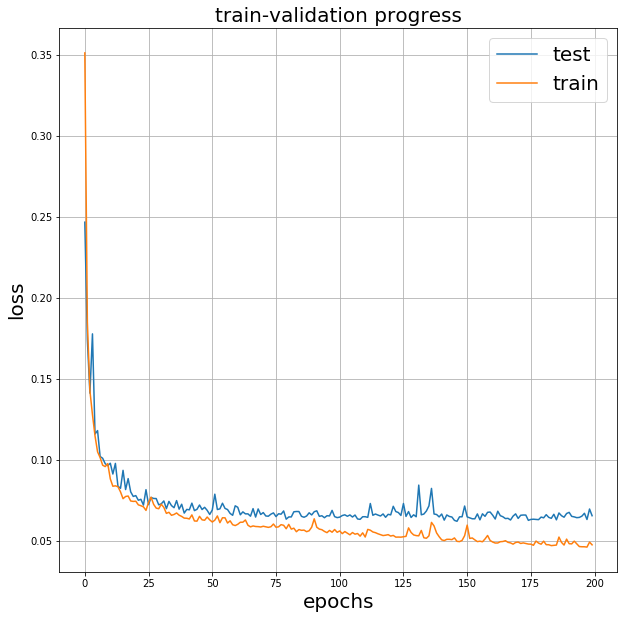

training completed!
weights loaded!
score_test: 0.06228
average dice: 0.92
------------------------------
('array shape: ', (603, 3, 128, 128), dtype('uint8'))
min: 0, max: 255, avg: 43.1, std:68.2
('array shape: ', (603, 1, 128, 128), dtype('uint8'))
min: 0, max: 1, avg: 0.153, std:0.36
('array shape: ', (67, 3, 128, 128), dtype('uint8'))
min: 0, max: 255, avg: 45.6, std:70.7
('array shape: ', (67, 1, 128, 128), dtype('uint8'))
min: 0, max: 1, avg: 0.151, std:0.358
------------------------------
('experiment:', 'trainTest3_hw_128by128_initfilts_16')
weights folder created
batch_size: 10, Augmentation: True
fold 3 training in progress ...
epoch: 0,  Current Learning Rate: 3.0e-04
score_train: 0.469693832482, score_test: 0.270331083616
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 1,  Current Learning Rate: 3.0e-04
score_train: 0.211007285536, score_test: 0.193098507599
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 2,  

epoch: 56,  Current Learning Rate: 3.0e-04
score_train: 0.0648643506496, score_test: 0.0657928905158
epoch: 57,  Current Learning Rate: 3.0e-04
score_train: 0.0642493717854, score_test: 0.0651044314588
epoch: 58,  Current Learning Rate: 3.0e-04
score_train: 0.0628923426072, score_test: 0.0640723455364
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 59,  Current Learning Rate: 3.0e-04
score_train: 0.0630125416193, score_test: 0.0644979220606
epoch: 60,  Current Learning Rate: 3.0e-04
score_train: 0.0628911751827, score_test: 0.0657841433396
epoch: 61,  Current Learning Rate: 3.0e-04
score_train: 0.0625307265095, score_test: 0.0635602863978
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 62,  Current Learning Rate: 3.0e-04
score_train: 0.0642117479967, score_test: 0.0650555069155
epoch: 63,  Current Learning Rate: 3.0e-04
score_train: 0.0629503673273, score_test: 0.0701177635633
epoch: 64,  Current Learning Rate: 3.0e-04
sco

score_train: 0.0586817868573, score_test: 0.0614455117941
epoch: 131,  Current Learning Rate: 3.0e-04
score_train: 0.0558354825177, score_test: 0.0607975950715
epoch: 132,  Current Learning Rate: 3.0e-04
score_train: 0.0559686504283, score_test: 0.0620290946716
epoch: 133,  Current Learning Rate: 3.0e-04
score_train: 0.0551592812473, score_test: 0.0596138891667
epoch: 134,  Current Learning Rate: 3.0e-04
score_train: 0.0544109482312, score_test: 0.062145103909
epoch: 135,  Current Learning Rate: 3.0e-04
score_train: 0.0561066391086, score_test: 0.0608085384175
epoch: 136,  Current Learning Rate: 3.0e-04
score_train: 0.0546634297565, score_test: 0.0622320355875
epoch: 137,  Current Learning Rate: 3.0e-04
score_train: 0.0546545790907, score_test: 0.0610330469573
epoch: 138,  Current Learning Rate: 3.0e-04
score_train: 0.0534330269578, score_test: 0.0587043073584
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 139,  Current Learning Rate: 3.0e-04
score_trai

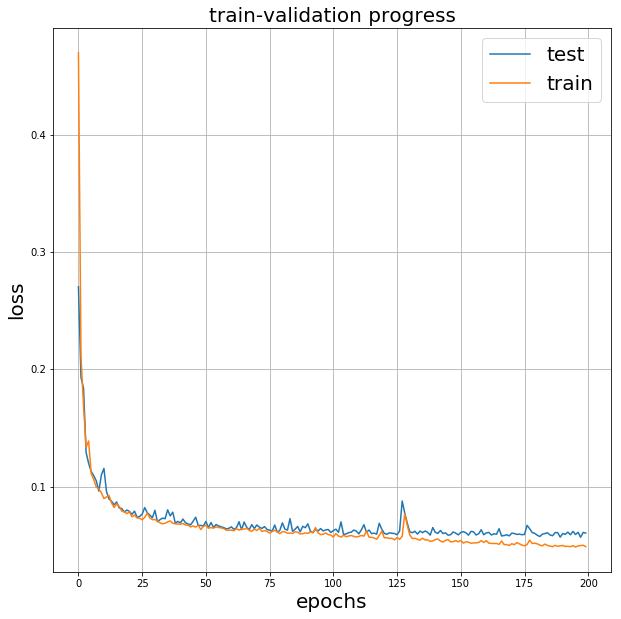

training completed!
weights loaded!
score_test: 0.05690
average dice: 0.91
------------------------------
('array shape: ', (603, 3, 128, 128), dtype('uint8'))
min: 0, max: 255, avg: 43.9, std:68.6
('array shape: ', (603, 1, 128, 128), dtype('uint8'))
min: 0, max: 1, avg: 0.154, std:0.361
('array shape: ', (67, 3, 128, 128), dtype('uint8'))
min: 0, max: 255, avg: 38.8, std:66.9
('array shape: ', (67, 1, 128, 128), dtype('uint8'))
min: 0, max: 1, avg: 0.144, std:0.351
------------------------------
('experiment:', 'trainTest3_hw_128by128_initfilts_16')
weights folder created
batch_size: 10, Augmentation: True
fold 4 training in progress ...
epoch: 0,  Current Learning Rate: 3.0e-04
score_train: 0.796546153094, score_test: 0.332749759083
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 1,  Current Learning Rate: 3.0e-04
score_train: 0.243998819693, score_test: 0.164640468003
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 2, 

epoch: 58,  Current Learning Rate: 3.0e-04
score_train: 0.0646557656872, score_test: 0.0567016470343
epoch: 59,  Current Learning Rate: 3.0e-04
score_train: 0.06442715901, score_test: 0.0566924450113
epoch: 60,  Current Learning Rate: 3.0e-04
score_train: 0.0660951666806, score_test: 0.0605007063097
epoch: 61,  Current Learning Rate: 3.0e-04
score_train: 0.0651952430705, score_test: 0.0546975932015
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 62,  Current Learning Rate: 3.0e-04
score_train: 0.065022034691, score_test: 0.0659353039158
epoch: 63,  Current Learning Rate: 3.0e-04
score_train: 0.064607643042, score_test: 0.0573848381416
epoch: 64,  Current Learning Rate: 3.0e-04
score_train: 0.0654687586659, score_test: 0.0557567343783
epoch: 65,  Current Learning Rate: 3.0e-04
score_train: 0.0657447270715, score_test: 0.0555665639799
epoch: 66,  Current Learning Rate: 3.0e-04
score_train: 0.064259722903, score_test: 0.0578431455947
epoch: 67,  Current Lea

score_train: 0.0565248850492, score_test: 0.0534775021361
epoch: 134,  Current Learning Rate: 3.0e-04
score_train: 0.0561361658212, score_test: 0.0612707827518
epoch: 135,  Current Learning Rate: 3.0e-04
score_train: 0.0569872346152, score_test: 0.0561353094987
epoch: 136,  Current Learning Rate: 3.0e-04
score_train: 0.0559482132, score_test: 0.0535095701022
epoch: 137,  Current Learning Rate: 3.0e-04
score_train: 0.0553379436742, score_test: 0.054039848607
epoch: 138,  Current Learning Rate: 3.0e-04
score_train: 0.0540672932654, score_test: 0.0534926710734
epoch: 139,  Current Learning Rate: 3.0e-04
score_train: 0.0531368312205, score_test: 0.0531565764947
epoch: 140,  Current Learning Rate: 3.0e-04
score_train: 0.0547601265607, score_test: 0.0510455214266
epoch: 141,  Current Learning Rate: 3.0e-04
score_train: 0.0539313856, score_test: 0.0528358554662
epoch: 142,  Current Learning Rate: 3.0e-04
score_train: 0.0540541911538, score_test: 0.0546927456536
epoch: 143,  Current Learning R

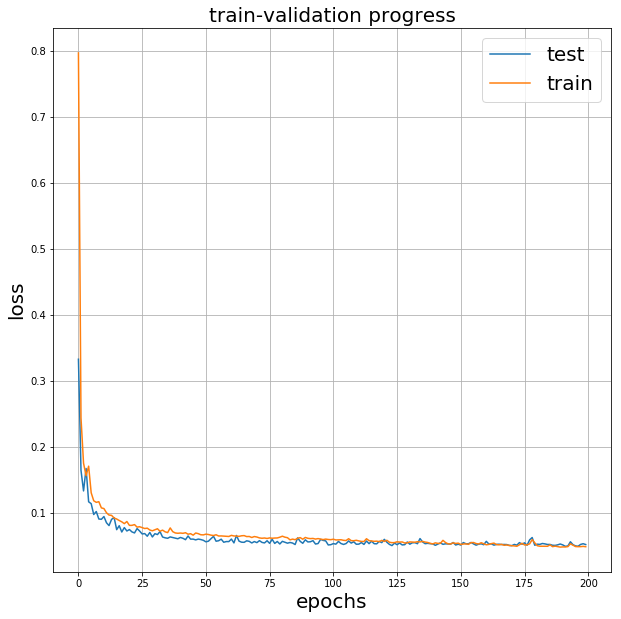

training completed!
weights loaded!
score_test: 0.04950
average dice: 0.92
------------------------------
('array shape: ', (603, 3, 128, 128), dtype('uint8'))
min: 0, max: 255, avg: 44.1, std:69.2
('array shape: ', (603, 1, 128, 128), dtype('uint8'))
min: 0, max: 1, avg: 0.155, std:0.362
('array shape: ', (67, 3, 128, 128), dtype('uint8'))
min: 0, max: 255, avg: 36.9, std:61.2
('array shape: ', (67, 1, 128, 128), dtype('uint8'))
min: 0, max: 1, avg: 0.135, std:0.342
------------------------------
('experiment:', 'trainTest3_hw_128by128_initfilts_16')
weights folder created
batch_size: 10, Augmentation: True
fold 5 training in progress ...
epoch: 0,  Current Learning Rate: 3.0e-04
score_train: 0.511020246331, score_test: 0.212073605674
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 1,  Current Learning Rate: 3.0e-04
score_train: 0.216301979117, score_test: 0.180300393323
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 2, 

score_train: 0.0644108641948, score_test: 0.0643058837628
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 58,  Current Learning Rate: 3.0e-04
score_train: 0.0642205788808, score_test: 0.0667210146785
epoch: 59,  Current Learning Rate: 3.0e-04
score_train: 0.0646336200102, score_test: 0.0627448961361
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 60,  Current Learning Rate: 3.0e-04
score_train: 0.0653358373365, score_test: 0.0708312495097
epoch: 61,  Current Learning Rate: 3.0e-04
score_train: 0.0665665594228, score_test: 0.0713489480706
epoch: 62,  Current Learning Rate: 3.0e-04
score_train: 0.0666344239273, score_test: 0.0660190551417
epoch: 63,  Current Learning Rate: 3.0e-04
score_train: 0.064517190751, score_test: 0.067513691734
epoch: 64,  Current Learning Rate: 3.0e-04
score_train: 0.0657595727055, score_test: 0.0661723763863
epoch: 65,  Current Learning Rate: 3.0e-04
score_train: 0.0644560220032, score_test: 0.0679

score_train: 0.0557392733681, score_test: 0.0578641048841
epoch: 132,  Current Learning Rate: 3.0e-04
score_train: 0.0547782470044, score_test: 0.0777819940626
epoch: 133,  Current Learning Rate: 3.0e-04
score_train: 0.0560365852407, score_test: 0.0584711817496
epoch: 134,  Current Learning Rate: 3.0e-04
score_train: 0.0533023311156, score_test: 0.0578541821564
epoch: 135,  Current Learning Rate: 3.0e-04
score_train: 0.0544717510294, score_test: 0.0583414542697
epoch: 136,  Current Learning Rate: 3.0e-04
score_train: 0.0553128455162, score_test: 0.0587493963262
epoch: 137,  Current Learning Rate: 3.0e-04
score_train: 0.0550829559243, score_test: 0.0577886067053
epoch: 138,  Current Learning Rate: 3.0e-04
score_train: 0.0536605360706, score_test: 0.0596142595272
epoch: 139,  Current Learning Rate: 3.0e-04
score_train: 0.0548888890206, score_test: 0.0579827512656
epoch: 140,  Current Learning Rate: 3.0e-04
score_train: 0.0560183813409, score_test: 0.0623116984741
epoch: 141,  Current Lea

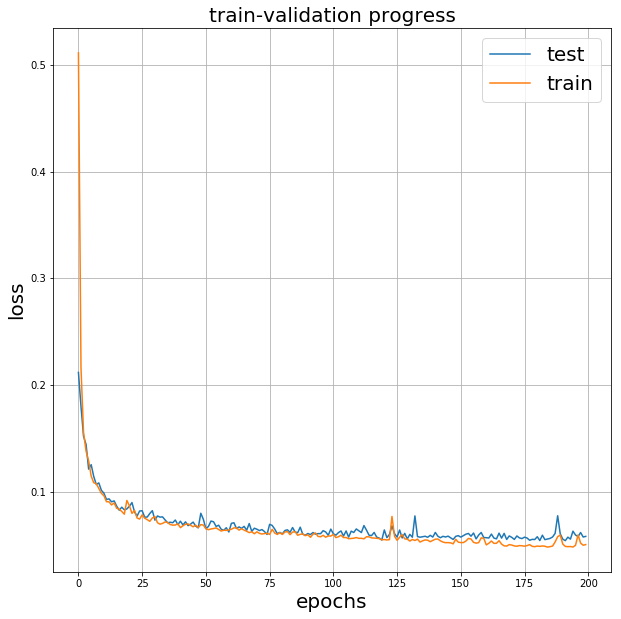

training completed!
weights loaded!
score_test: 0.05463
average dice: 0.91
------------------------------
average score for 5 folds is 0.0574763872063


In [8]:
n_folds=5
skf = ShuffleSplit(n_splits=n_folds, test_size=0.1, random_state=321)

# loop over folds
foldnm=0
scores_nfolds=[]

print ('wait ...')
for train_ind, test_ind in skf.split(X,Y):
    foldnm+=1    

    train_ind=list(np.sort(train_ind))
    test_ind=list(np.sort(test_ind))
    
    X_train,Y_train=X[train_ind],np.array(Y[train_ind],'uint8')
    X_test,Y_test=X[test_ind],np.array(Y[test_ind],'uint8')
    
    array_stats(X_train)
    array_stats(Y_train)
    array_stats(X_test)
    array_stats(Y_test)
    print ('-'*30)

    # exeriment name to record weights and scores
    experiment=netinfo+'_hw_'+str(h)+'by'+str(w)+'_initfilts_'+str(params_train['initial_channels'])
    print ('experiment:', experiment)

    weightfolder='./output/weights/'+experiment+'/fold'+str(foldnm)
    if  not os.path.exists(weightfolder):
        os.makedirs(weightfolder)
        print ('weights folder created')    
    
    # path to weights
    path2weights=weightfolder+"/weights.hdf5"
    path2model=weightfolder+"/model.hdf5"    
    
    # train test on fold #
    params_train['foldnm']=foldnm
    params_train['learning_rate']=initialLearningRate
    params_train['path2weights']=path2weights
    params_train['path2model']=path2model
    model=model_skip(params_train)
    #model.summary()    
    train_test_model(X_train,Y_train,X_test,Y_test,params_train)
    
    # loading best weights from training session
    if  os.path.exists(path2weights):
        model.load_weights(path2weights)
        print 'weights loaded!'
    else:
        raise IOError('weights does not exist!!!')
    
    score_test=model.evaluate(preprocess(X_test,norm_type),Y_test,verbose=0,batch_size=8)
    print ('score_test: %.5f' %(score_test))    
    Y_pred=model.predict(preprocess(X_test,norm_type))>0.5
    dicePerFold,_=calc_dice(Y_test,Y_pred)
    print('average dice: %.2f' %dicePerFold)
    print ('-' *30)
    # store scores for all folds
    scores_nfolds.append(score_test)

print ('average score for %s folds is %s' %(n_folds,np.mean(scores_nfolds)))    

### diaply predictions

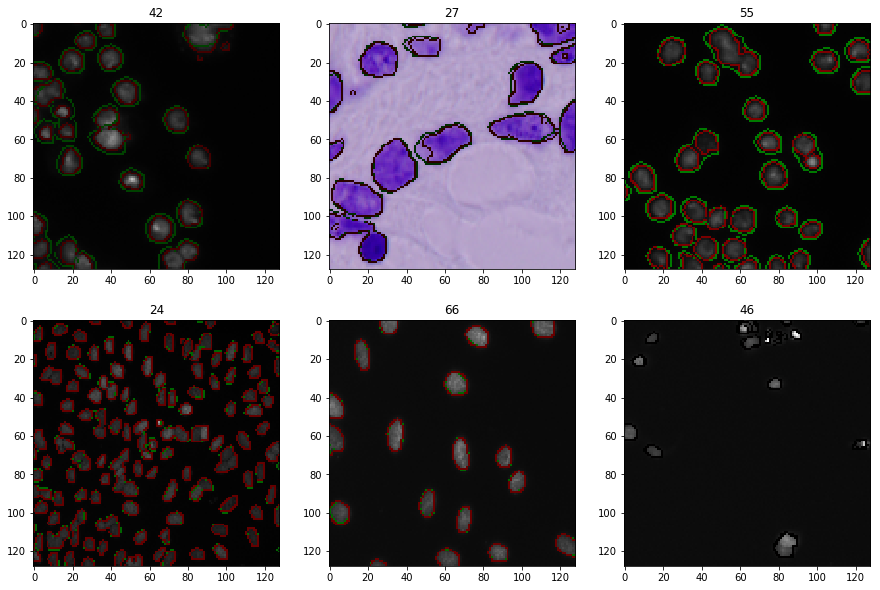

In [9]:
plt.figure(figsize=(15,10))
disp_img_2masks(X_test,Y_test,Y_pred,r=2,c=3)

### display after resizing

('array shape: ', (256, 320), dtype('float64'))
min: 0.0, max: 1.0, avg: 0.351, std:0.45
('array shape: ', (3, 256, 320), dtype('uint8'))
min: 16, max: 225, avg: 1.73e+02, std:46.4


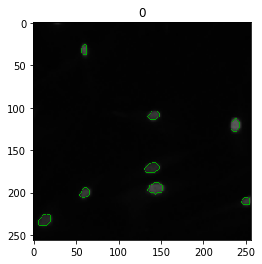

In [10]:
Y_testResized=resizeY(Y_pred,HW_train[test_ind])
X_testResized=resizeX(X_test,HW_train[test_ind])
array_stats(Y_testResized[0])
array_stats(X_testResized[0])

#disp_img_2masks(X_test,Y_test,Y_pred,r=2,c=3)
n1=np.random.randint(len(X_testResized))
disp_img_2masks(X_testResized[n1][np.newaxis],Y_testResized[n1][np.newaxis,np.newaxis],r=1,c=1)

## Predict on Leaderboard Data

loading ../data/trainTestH128W128.hdf5
('array shape: ', (65, 3, 128, 128), dtype('uint8'))
min: 0, max: 255, avg: 53.4, std:74.8
('array shape: ', (65, 3), dtype('uint16'))
min: 3, max: 696, avg: 2.66e+02, std:2.28e+02


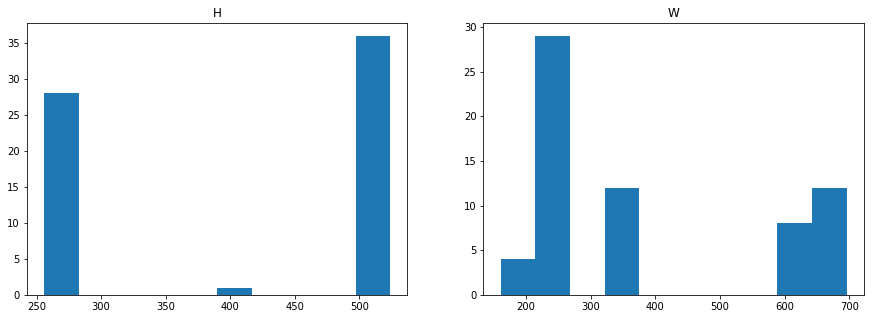

fold: 1
experiment: trainTest3_hw_128by128_initfilts_16
./output/weights/trainTest3_hw_128by128_initfilts_16/fold1/weights.hdf5 loaded!
('array shape: ', (65, 1, 128, 128), dtype('float32'))
min: 7.17654364754e-12, max: 1.0, avg: 0.141, std:0.309
--------------------------------------------------
fold: 2
experiment: trainTest3_hw_128by128_initfilts_16
./output/weights/trainTest3_hw_128by128_initfilts_16/fold2/weights.hdf5 loaded!
('array shape: ', (65, 1, 128, 128), dtype('float32'))
min: 0.0, max: 1.0, avg: 0.149, std:0.32
--------------------------------------------------
fold: 3
experiment: trainTest3_hw_128by128_initfilts_16
./output/weights/trainTest3_hw_128by128_initfilts_16/fold3/weights.hdf5 loaded!
('array shape: ', (65, 1, 128, 128), dtype('float32'))
min: 3.47710228608e-23, max: 1.0, avg: 0.143, std:0.316
--------------------------------------------------
fold: 4
experiment: trainTest3_hw_128by128_initfilts_16
./output/weights/trainTest3_hw_128by128_initfilts_16/fold4/weight

In [11]:
X_leader,_,HW_leader=loadData(path2h5,'leader')
array_stats(X_leader)
array_stats(HW_leader)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(HW_leader[:,0])
plt.title('H')
plt.subplot(1,2,2)
plt.hist(HW_leader[:,1])
plt.title('W')
plt.show()

n_folds=5
# prediction for nfolds
Y_leaderAllFolds=[]
for foldnm in range(1,n_folds+1):
    print('fold: %s' %foldnm)
    # load weights
    experiment=netinfo+'_hw_'+str(h)+'by'+str(w)+'_initfilts_'+str(params_train['initial_channels'])
    print ('experiment: %s' %experiment)
    weightfolder='./output/weights/'+experiment+'/fold'+str(foldnm)
    # path to weights
    path2weights=weightfolder+"/weights.hdf5"
    if  os.path.exists(path2weights):
        model.load_weights(path2weights)
        print ('%s loaded!' %path2weights)
    else:
        raise IOError ('weights does not exist!')

    # prediction
    Y_leader_perfold=model.predict(preprocess(X_leader.value,norm_type))
    array_stats(Y_leader_perfold)
    Y_leaderAllFolds.append(Y_leader_perfold)        
    print('-'*50)

# convert to array
Y_leader=np.hstack(Y_leaderAllFolds)
print ('ensemble shape:', Y_leader.shape)
Y_leader=np.mean(Y_leader,axis=1)[:,np.newaxis]
array_stats(Y_leader)

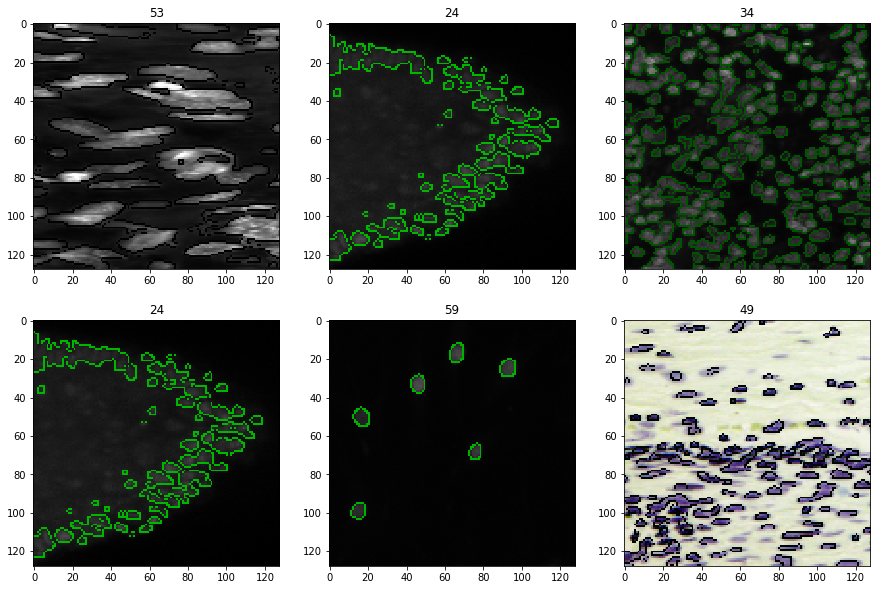

In [12]:
plt.figure(figsize=(15,10))
disp_img_2masks(X_leader,Y_leader>0.5,r=2,c=3)

### display after resizing 

('array shape: ', (256, 256), dtype('float64'))
min: 0.0, max: 1.0, avg: 0.0183, std:0.126
('array shape: ', (3, 256, 256), dtype('uint8'))
min: 1, max: 72, avg: 3.72, std:4.67
('array shape: ', (512, 680), dtype('float64'))
min: 0.0, max: 1.0, avg: 0.177, std:0.356
('array shape: ', (3, 512, 680), dtype('uint8'))
min: 0, max: 254, avg: 1.94e+02, std:52.5
56 da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab


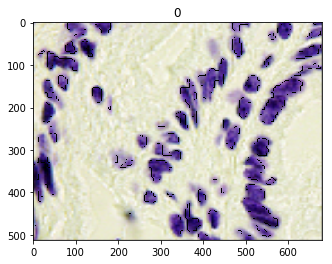

In [13]:
Y_leaderResized=resizeY(Y_leader>0.5,HW_leader)
X_leaderResized=resizeX(X_leader,HW_leader)
array_stats(Y_leaderResized[0])
array_stats(X_leaderResized[0])

#disp_img_2masks(X_test,Y_test,Y_pred,r=2,c=3)
n1=np.random.randint(len(X_leaderResized))
array_stats(Y_leaderResized[n1])
array_stats(X_leaderResized[n1])
print n1,test_ids[n1]
disp_img_2masks(X_leaderResized[n1][np.newaxis],Y_leaderResized[n1][np.newaxis,np.newaxis],r=1,c=1)

In [14]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)
        
        

In [15]:
array_stats(Y_leader)
Y_leaderResized=resizeY(Y_leader,HW_leader)
array_stats(Y_leaderResized[0])

new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(Y_leaderResized[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

('array shape: ', (65, 1, 128, 128), dtype('float32'))
min: 4.51248732825e-10, max: 1.0, avg: 0.147, std:0.31
('array shape: ', (256, 256), dtype('float64'))
min: 4.09972926718e-07, max: 0.999943938106, avg: 0.0185, std:0.123


In [16]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

now = datetime.datetime.now()
info=experiment
suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
submissionFolder='./output/submissions'
if not os.path.exists(submissionFolder):
    os.mkdir(submissionFolder)
    print(submissionFolder+ ' created!')
path2submission = os.path.join(submissionFolder, 'submission_' + suffix + '.csv')
print(path2submission)
sub.to_csv(path2submission, index=False)
sub.head()

./output/submissions/submission_trainTest3_hw_128by128_initfilts_16_2018-02-04-06-01.csv


,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,45103 10 45359 11 45613 14 45869 14 46125 14 4...
1,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50278 10 50533 12 50787 14 51043 15 51298 16 5...
2,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,10891 7 11147 8 11401 10 11656 12 11911 13 121...
3,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,31133 3 31376 5 31388 5 31631 8 31644 6 31883 ...
4,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50841 6 51096 7 51349 11 51605 12 51860 13 521...
